### About this document
This is the assignment for the UCL CASA module Data Science for Spatial Systems (CASA0006)
This is a self contained Jupyter notebook with structure introduction, discussion and embeded code
and bibliography.

Code is hosted here  <br/>

Data is availble here <br/>


# Traffic forecasting using graph neural networks and LSTM

**Author:** JIANHONG LIU<br>
**Description:** This paper demonstrates how to do timeseries forecasting over graphs.

## 1.0 | Introduction
Accurate and real-time traffic flow prediction is crucial in intelligent transportation systems (ITS), especially for traffic control. Existing models such as ARMA and ARIMA are mainly linear models, which cannot capture the randomness and non-linearity of traffic flow, resulting in low prediction accuracy.

In recent years, deep learning methods have been proposed as a new option for traffic flow prediction. This article demonstrates how to use graph neural networks and LSTM to predict traffic conditions. Specifically, we are interested in predicting the future values of traffic speed given the historical traffic speed of a set of road segments.

A approach to solving this problem is to treat the traffic speed of each road segment as a separate time series and predict the future values of each time series using past values from the same time series. 

However, this approach ignores the influence of a road segment's traffic speed on adjacent segments. To be able to consider the complex interactions between traffic speeds on a group of adjacent roads, we can define the traffic network as a graph and treat traffic speed as a signal on that graph.

In this paper, we implement a neural network architecture that can handle time series data on graphs. We first show how to process the data and create a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)for prediction through the graph. Then, we implement a model that uses graph convolutional and LSTM layers to perform predictions on the graph.

## 1.1 | Requirements to run the analysis

In [47]:
# Packages for data manipulation and processing
import pandas as pd
import numpy as np
import os
import typing

# Packages for visualisation
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 2.0 | Literature review

### Literature
Accurate and timely traffic flow information is currently in high demand by travellers, the commercial sector, and government agencies (N. Zhang et al., 2018). It has the potential to assist road users in making better travel decisions and improve traffic operation efficiency. The purpose of traffic flow prediction is to provide such traffic flow information. With the rapid development and deployment of intelligent transportation systems (ITS), traffic flow prediction is receiving increasing attention. It is considered a critical element for the successful deployment of ITS subsystems.

In the 1970s, the Autoregressive Integrated Moving Average (ARIMA) model was used to forecast short-term highway traffic flow (Ahmed and Cook, 1979). Researchers from various fields such as transportation engineering, statistics, machine learning, control engineering, and economics have proposed various traffic flow forecasting models. Previous prediction methods can be classified into three categories: parametric techniques, non-parametric methods, and simulation. Parametric models include time series models, Kalman filtering models, etc., while non-parametric models include k-nearest neighbor (k-NN) methods, artificial neural networks (ANN), etc. Simulation methods use traffic simulation tools to predict traffic flow.

The technical basis for traffic flow prediction problems is based on time series methods. Levin and Tsao applied Box-Jenkins time series analysis to predict highway traffic flow and found that the ARIMA (0, 1, 1) model had the highest statistical significance for all predictions(Levin and Tsao, 1980). Hamid et al. applied ARIMA models to predict traffic volume on urban arterial roads (M. Hamed et al., 1995). Many ARIMA variants have been proposed to improve prediction accuracy, such as Kohonen-ARIMA (KARIMA)(M. vanderVoort et al., 1996), ARIMA subset(Lee and Fambro, 1999), ARIMA with explanatory variables (ARIMAX) (B. M. Williams, 2001), Vector Autoregressive Moving Average (VARMA) and Space-Time ARIMA (Kamarianakis and Prastacos, 2003), and Seasonal ARIMA (SARIMA) (Williams and Hoel. 2003). In addition to ARIMA-like time series models, other approaches such as machine learning algorithms and hybrid models have also been explored to forecast traffic flow.

In recent years, deep learning methods have been successfully applied to various traffic tasks,such as, deep belief network (DBN)(Jia et al., 2016; Huanget al., 2014), stacked autoencoder (SAE)(Lv et al., 2015;Chen et al., 2016).However, they are difficult to jointly extract spatial and temporal features from the input.

In order to make full use of spatial information, this paper uses a general graph to simulate the traffic network
Process it individually (e.g. grid or segment). To deal with the inherent defects of recurrent networks, this paper adopts a fully convolutional structure on the time axis. Using a very novel method, spatio-temporal graph convolutional network (Yu et al., 2018), we use it to complete the task of traffic flow prediction. The architecture contains several spatio-temporal convolutional blocks, which are combined layers of graph convolutions [Defferrard et al., 2016] and convolutional sequence learning layers to model spatial and temporal dependencies.


## 3.0 | Data preparation

### 3.1 | Data description

The PeMSD7 dataset is collected in real-time from over 39,000 sensor stations deployed in the major metropolitan areas of the California highway system through the Caltrans Performance Measurement System (PeMS). The dataset is also aggregated from 30-second data samples to 5-minute intervals. This paper randomly selects a large-scale dataset containing 1,026 stations from the 7th district of California. The time range of the PeMSD7 dataset is the workdays of May and June 2012.

The data consists of two files:

W_1026.csv contains the distances between 1,026 stations in the 7th district of California.</br>
V_1026.csv contains the traffic speed collected for these stations on workdays in May and June 2012.

The full description of the dataset can be found in
[data](https://github.com/jianhongliu99/CASA0006/blob/main/W_1026.csv).

### 3.2| Loading data

In [48]:

road_distances = pd.read_csv('W_1026.csv', header=None).to_numpy()
speeds_array = pd.read_csv('V_1026.csv', header=None).to_numpy()

print(f"road_distances shape={road_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

road_distances shape=(1026, 1026)
speeds_array shape=(12672, 1026)


Note:I don't know why the github data can only be imported locally, otherwise the parsing error will occur. I have put the data on github, and at the same time I have put the data and the python file in a folder.

### 3.3 | sub-sampling roads

To reduce the problem size and make the training faster, we will only
work with a sample of 26 roads out of the 228 roads in the dataset.
We have chosen the roads by starting from road 0, choosing the 5 closest
roads to it, and continuing this process until we get 25 roads. You can choose
any other subset of the roads. We chose the roads in this way to increase the likelihood
of having roads with correlated speed timeseries.
`sample_routes` contains the IDs of the selected roads.

In [49]:
sample_roads = [
    0,
    42,
    84,
    126,
    174,
    217,
    265,
    325,
    398,
    421,
    498,
    530,
    574,
    614,
    678,
    712,
    765,
    812,
    840,
    865,
    873,
    899,
    912,
    975,
    999,
    1023,
]
road_distances = road_distances[np.ix_(sample_roads, sample_roads)]
speeds_array = speeds_array[:, sample_roads]

print(f"road_distances shape={road_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

road_distances shape=(26, 26)
speeds_array shape=(12672, 26)


### 3.4 | Data visualization

Here are the timeseries of the traffic speed for two of the routes:

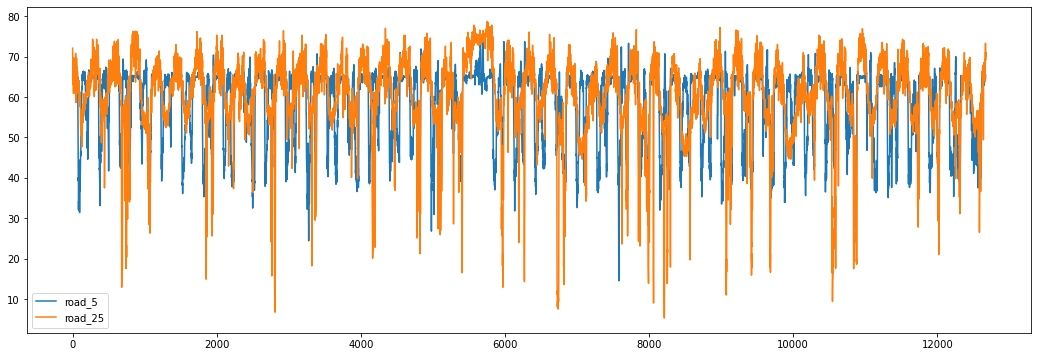

In [50]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [1, 2]])
plt.legend(["road_5", "road_25"])

We can also visualize the correlation between the timeseries in different routes.

Text(0, 0.5, 'route number')

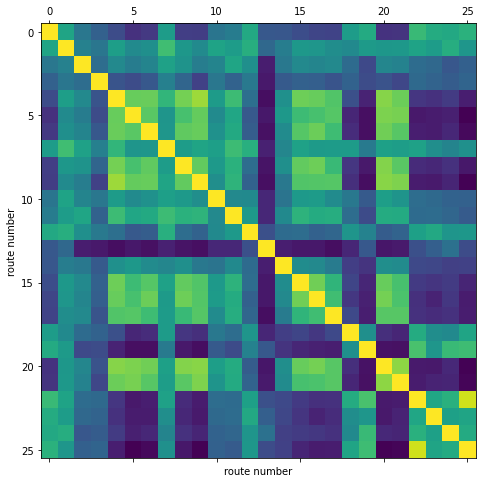

In [51]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("route number")
plt.ylabel("route number")

Using this correlation heatmap, we can see that for example the speed in
routes 4, 5, 6 are highly correlated.

### 3.5 | Splitting and normalizing data

Next, we split the speed values array into train/validation/test sets,
and normalize the resulting arrays:

In [52]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


### 3.6 | Creating TensorFlow Datasets

The objective of our forecasting problem is to predict the future values of road speed for times t+T+1, ..., t+T+h, given a sequence of road speed values at times t+1, t+2, ..., t+T. The input to this model at each time t consists of T vectors, each of size N, where N represents the number of roads. The output, or target, of our model is h vectors, each of size N.

We employ the Keras built-in function timeseries_dataset_from_array() to create datasets for our forecasting task. The input to our model at each time step t consists of T vectors, each of size N, where N is the number of roads, and the output is a forecast of h vectors, each of size N, for time steps t+T+1, ..., t+T+h. We set input_sequence_length to T and forecast_horizon to h in the function create_tf_dataset() below.

The parameter multi_horizon requires further explanation. Assuming forecast_horizon=3, if multi_horizon=True, the model generates forecasts for time steps t+T+1, t+T+2, t+T+3, resulting in a target tensor with shape (T,3). In contrast, if multi_horizon=False, the model only predicts the speed for time step t+T+3, resulting in a target tensor with shape (T,1).

Note that the input tensor for each batch has shape (batch_size, input_sequence_length, num_routes, 1). The last dimension is added to increase the model's flexibility, allowing for multiple timeseries features for each road at each time step. For example, one might include temperature timeseries in addition to historical speed values as input features. However, in this example, the last dimension of the input is always 1.


In [55]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


### 3.7 Roads Graph

As previously stated, we consider the road segments to be nodes of a graph. The distances between the nodes are provided in the PeMSD7 dataset, and we use these distances to create the graph's adjacency matrix.

In [56]:

def compute_adjacency_matrix(
    road_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = road_distances.shape[0]
    road_distances = road_distances / 10000.0
    w2, w_mask = (
        road_distances * road_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask


The function `compute_adjacency_matrix()` returns a boolean adjacency matrix
where 1 means there is an edge between two nodes. We use the following class
to store the information about the graph.

In [57]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(road_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 6


## 4.0 | Model Built

This paper is used to predict that the graph model is composed of graph convolution
layer and LSTM layer

### 4.1 ｜ Graph convolution layer

Our graph convolution layer implementation is similar to the one provided in the Keras example for graph neural networks and citation networks. However, there is a difference in the input format, where in our case, the input to the layer is a 4D tensor of shape (num_nodes, batch_size, input_seq_length, in_feat). This layer executes the following steps:

First, the nodes' representations are computed using self.compute_nodes_representation() by multiplying the input features by self.weight.

Next, in self.compute_aggregated_messages(), the layer computes the aggregated messages of the neighbors. This is accomplished by first aggregating the neighbors' representations and then multiplying the results by self.weight.

Finally, in self.update(), the layer computes the final output by combining the nodes' representations and the neighbors' aggregated messages.

In [58]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


### 4.2 ｜ LSTM plus graph convolution

After applying the graph convolution layer to the input tensor, the resulting 4D tensor contains the nodes' representations over time, where each node's representation is informed by the information from its neighbors. To further process this information over time, we pass each node's tensor through a recurrent layer. The LSTMGC layer applies a graph convolution layer to the inputs and then feeds the resulting tensor into an LSTM layer. The output of this layer is then passed through a fully connected layer to generate the final predictions.

In [59]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## 5. 0 ｜ Model training

In [60]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20


2023-04-24 06:20:53.462367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype int32 and shape [6322]
	 [[{{node Placeholder/_33}}]]
2023-04-24 06:20:53.463153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6333,26,1]
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - ETA: 0s - loss: 0.8386

2023-04-24 06:21:02.283518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype double and shape [2522,26]
	 [[{{node Placeholder/_25}}]]
2023-04-24 06:21:02.284374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_38' with dtype int32
	 [[{{node Placeholder/_38}}]]


99/99 [==============================] - 11s 90ms/step - loss: 0.8386 - val_loss: 0.6652
Epoch 2/20
99/99 [==============================] - 9s 88ms/step - loss: 0.3908 - val_loss: 0.4570
Epoch 3/20
99/99 [==============================] - 8s 81ms/step - loss: 0.2609 - val_loss: 0.2621
Epoch 4/20
99/99 [==============================] - 8s 85ms/step - loss: 0.1861 - val_loss: 0.2068
Epoch 5/20
99/99 [==============================] - 8s 84ms/step - loss: 0.1530 - val_loss: 0.1726
Epoch 6/20
99/99 [==============================] - 10s 100ms/step - loss: 0.1319 - val_loss: 0.1563
Epoch 7/20
99/99 [==============================] - 10s 100ms/step - loss: 0.1232 - val_loss: 0.1490
Epoch 8/20
99/99 [==============================] - 10s 101ms/step - loss: 0.1191 - val_loss: 0.1446
Epoch 9/20
99/99 [==============================] - 8s 82ms/step - loss: 0.1165 - val_loss: 0.1418
Epoch 10/20
99/99 [==============================] - 8s 84ms/step - loss: 0.1149 - val_loss: 0.1398
Epoch 11/20
9

## 6.0 Making forecasts on test set

We can now employ the trained model to generate forecasts for the test set. Subsequently, we calculate the mean absolute error (MAE) of the model and compare it to the MAE of naive forecasts, which are derived by using the last known value of the speed for each node.


2023-04-24 06:26:27.489655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-24 06:26:27.491589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


119/119 [==============================] - 2s 20ms/step
naive MAE: 0.19596772270383714, model MAE: 0.18668475003348164


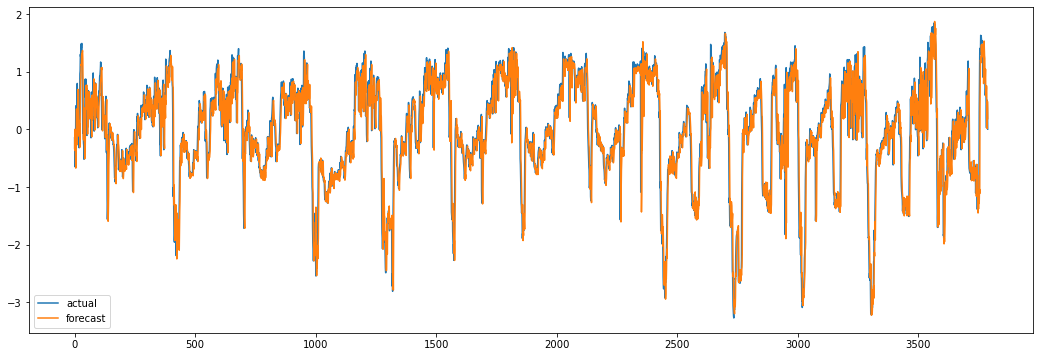

In [61]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

## 7.0 ｜Discussion and conclusion

In this paper, it uses a novel deep learning framework for traffic prediction, integrating graph convolution and gated temporal convolution through spatiotemporal convolution blocks. Experiments show that the model works well in traffic flow prediction in the real world.
In the future, this paper will further optimize the network structure and parameter settings.

## 8.0 ｜Reference


B. M. Williams. 2001. Multivariate vehicular traffic flow prediction—Evaluation of ARIMAX modeling. Transportation Research Record, no. 1776, pp. 194-200.

Chen, Q., Song, X., Yamada, H., & Shibasaki, R. 2016. Learning deep representation from big and heterogeneous data for traffic accident inference. In AAAI, pp. 338-344.

Defferrard, M., Bresson, X., & Vandergheynst, P. 2016 . Convolutional neural networks on graphs with fast localized spectral filtering. In NIPS, pp. 3844-3852.

Huang. W, Song. G, Hong. H,  Xie, K. 2014. Deep architecture for traffic flow prediction: deep belief networks with multitask learning. IEEE Transactions on Intelligent Transportation Systems, 15(5), 2191-2201.

Jia. Y, Wu. J and Du. Y. 2016. Traffic speed prediction using deep learning method. In ITSC,pp. 1217-1222

Lv, Y., Duan, Y., Kang, W., Li, Z., & Wang, F.-Y. 2015. Traffic flow prediction with big data: a deep learning approach. IEEE Transactions on Intelligent Transportation Systems, 16(2). 865-873.

M. Hamed, H. Al-Masaeid and Z. Said. 1995. Short-term prediction of traffic volume in urban arterials. Journal of Transportation Engineering, vol. 121, no. 3, pp. 249-254.

M. Levin and Y.-D. Tsao. 1980. On forecasting freeway occupancies and volumes. Transportation Research Record, no. 773, pp. 47-49.

M. S. Ahmed and A. R. Cook. 1979. Analysis of freeway traffic time-series data by using Box–Jenkins techniques. Transportation Research Record, no. 722, pp. 1-9.

M. vanderVoort, M. Dougherty and S. Watson. 1996. Combining Kohonen maps with ARIMA time series models to forecast traffic flow. Transportation Research Part C: Emerging Technologies, vol. 4, no. 5, pp. 307-318.

N. Zhang, F.-Y. Wang, F. Zhu, D. Zhao and S. Tang. 2008. DynaCAS: Computational experiments and decision support for ITS. IEEE Intelligent Systems, vol. 23, no. 6, pp. 19-23, Nov./Dec.

S. Lee and D. Fambro. 1999. Application of subset autoregressive integrated moving average model for short-term freeway traffic volume forecasting. Transportation Research Record, vol. 1678, pp. 179-188.

Y. Kamarianakis and P. Prastacos. 2003. Forecasting traffic flow conditions in an urban network—Comparison of multivariate and univariate approaches. Transportation Research Record, no. 1857, pp. 74-84.

